In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier  

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)



In [2]:
# Load data
df = pd.read_csv(r'C:\Users\ask12\Desktop\ML Projects\Churn Prediction\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Drop customerID (not predictive)
df.drop(columns=["customerID"], inplace=True)

# Quick checks
print(df.shape)
print(df.columns)
df.head()

(7043, 20)
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Convert 'TotalCharges' to numeric (some values are empty strings)
# Use 'coerce' to convert errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows where TotalCharges is NaN
df.dropna(subset=['TotalCharges'], inplace=True)

# Optional: reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Confirm change
print(df['TotalCharges'].dtype)
print(df.shape)

float64
(7032, 20)


In [4]:
# Assuming df is your DataFrame
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_cols)


Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [5]:
encoder = LabelEncoder()
for feature in categorical_cols:
    df[feature] = encoder.fit_transform(df[feature])

In [6]:
# splitting dataset into dependent and independent feature
X = df.drop(columns='Churn')
y = df['Churn']

In [7]:
from sklearn.feature_selection import SelectKBest, f_classif  # or chi2, mutual_info_classif

selector = SelectKBest(score_func=f_classif, k=10)  # change k as needed
X_selected = selector.fit_transform(X, y)


In [8]:
# Assuming X is a DataFrame
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]
print("Selected Features:", selected_features.tolist())


Selected Features: ['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges']


In [9]:
# splitting for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Log_reg = LogisticRegression(C=150, max_iter=150)
Log_reg.fit(X_train, y_train)

log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(y_test, log_pred)}')
print(f'Confusion matrix :\n{confusion_matrix(y_test, log_pred)}')
print(f'Classification report :\n{classification_report(y_test, log_pred)}')


Accuracy score : 0.7931769722814499
Confusion matrix :
[[905 108]
 [183 211]]
Classification report :
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1013
           1       0.66      0.54      0.59       394

    accuracy                           0.79      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.78      0.79      0.79      1407



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

Rfc = RandomForestClassifier(
    n_estimators=120,
    criterion='gini',
    max_depth=15,
    min_samples_leaf=10,
    min_samples_split=5
)

Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

# Correct metric order: y_true, y_pred
print(f'Accuracy score : {accuracy_score(y_test, rfc_pred)}')
print(f'Confusion matrix :\n{confusion_matrix(y_test, rfc_pred)}')
print(f'Classification report :\n{classification_report(y_test, rfc_pred)}')

# Optional: ROC-AUC score
rfc_probs = Rfc.predict_proba(X_test)[:, 1]
print(f'ROC-AUC score : {roc_auc_score(y_test, rfc_probs)}')


Accuracy score : 0.7860696517412935
Confusion matrix :
[[924  89]
 [212 182]]
Classification report :
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1013
           1       0.67      0.46      0.55       394

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.70      1407
weighted avg       0.77      0.79      0.77      1407

ROC-AUC score : 0.8383238708966181


In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

xgb_model = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    use_label_encoder=False,
    eval_metric='logloss'  # avoid warning for classification
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Evaluation
print(f'Accuracy score : {accuracy_score(y_test, xgb_pred)}')
print(f'Confusion matrix :\n{confusion_matrix(y_test, xgb_pred)}')
print(f'Classification report :\n{classification_report(y_test, xgb_pred)}')

# ROC-AUC
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
print(f'ROC-AUC score : {roc_auc_score(y_test, xgb_probs)}')


Accuracy score : 0.7917555081734187
Confusion matrix :
[[911 102]
 [191 203]]
Classification report :
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1013
           1       0.67      0.52      0.58       394

    accuracy                           0.79      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC score : 0.830006865068826


In [13]:
from imblearn.combine import SMOTEENN
from collections import Counter

# Initialize SMOTEENN
st = SMOTEENN(random_state=42)

# Apply SMOTE + Edited Nearest Neighbors
X_train_st, y_train_st = st.fit_resample(X_train, y_train)

# Print class distribution
print("The number of classes before fit:", Counter(y_train))
print("The number of classes after fit :", Counter(y_train_st))


The number of classes before fit: Counter({0: 4150, 1: 1475})
The number of classes after fit : Counter({1: 2616, 0: 2172})


In [14]:
# splitting the over sampling dataset 
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [15]:
# Random forest classifier
Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9269311064718163
Confusion matrix :
 [[394  20]
 [ 50 494]]
Classification report :
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       414
           1       0.96      0.91      0.93       544

    accuracy                           0.93       958
   macro avg       0.92      0.93      0.93       958
weighted avg       0.93      0.93      0.93       958



In [16]:
# logistic regression
Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.918580375782881
Confusion matrix :
 [[405  39]
 [ 39 475]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       444
           1       0.92      0.92      0.92       514

    accuracy                           0.92       958
   macro avg       0.92      0.92      0.92       958
weighted avg       0.92      0.92      0.92       958



In [17]:
from xgboost import XGBClassifier

xgb_sampling = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_sampling.fit(X_train_sap, y_train_sap)
xgb_sampling_pred = xgb_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(y_test_sap, xgb_sampling_pred)}')
print(f'Confusion matrix :\n{confusion_matrix(y_test_sap, xgb_sampling_pred)}')
print(f'Classification report :\n{classification_report(y_test_sap, xgb_sampling_pred)}')

# ROC-AUC
xgb_sampling_probs = xgb_sampling.predict_proba(X_test_sap)[:, 1]
print(f'ROC-AUC score : {roc_auc_score(y_test_sap, xgb_sampling_probs)}')


Accuracy score : 0.9519832985386222
Confusion matrix :
[[414  30]
 [ 16 498]]
Classification report :
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       444
           1       0.94      0.97      0.96       514

    accuracy                           0.95       958
   macro avg       0.95      0.95      0.95       958
weighted avg       0.95      0.95      0.95       958

ROC-AUC score : 0.9897553195218565


In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,  # Number of combinations to try (increase for better results)
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train_sap, y_train_sap)
print("Best Parameters:", random_search.best_params_)

best_xgb = random_search.best_estimator_

y_pred = best_xgb.predict(X_test_sap)
y_prob = best_xgb.predict_proba(X_test_sap)[:, 1]

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

print(f'Accuracy : {accuracy_score(y_test_sap, y_pred)}')
print(f'Confusion matrix:\n{confusion_matrix(y_test_sap, y_pred)}')
print(f'Classification report:\n{classification_report(y_test_sap, y_pred)}')
print(f'ROC-AUC : {roc_auc_score(y_test_sap, y_prob)}')



Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best Parameters: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
Accuracy : 0.9519832985386222
Confusion matrix:
[[415  29]
 [ 17 497]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       444
           1       0.94      0.97      0.96       514

    accuracy                           0.95       958
   macro avg       0.95      0.95      0.95       958
weighted avg       0.95      0.95      0.95       958

ROC-AUC : 0.9914466996179058


In [19]:
import pandas as pd

# Example new customer input (replace with real values)
new_customer = pd.DataFrame([{
    'gender': 1,
    'SeniorCitizen': 0,
    'Partner': 0,
    'Dependents': 0,
    'tenure': 2,
    'PhoneService': 1,
    'MultipleLines': 0,
    'InternetService': 2,
    'OnlineSecurity': 0,
    'OnlineBackup': 1,
    'DeviceProtection': 0,
    'TechSupport': 0,
    'StreamingTV': 1,
    'StreamingMovies': 0,
    'Contract': 0,
    'PaperlessBilling': 1,
    'PaymentMethod': 2,
    'MonthlyCharges': 95.7,
    'TotalCharges': 170.1
}])

# Predict churn probability and class
churn_prob = best_xgb.predict_proba(new_customer)[0, 1]
churn_pred = best_xgb.predict(new_customer)[0]

print(f"Prediction: {'Churn' if churn_pred == 1 else 'No Churn'}")
print(f"Churn Probability: {churn_prob:.4f}")


Prediction: Churn
Churn Probability: 0.9986


In [20]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

In [21]:
#Logistic Regression
Log_reg_smt = LogisticRegression(C=10, max_iter=150)    
Log_reg_smt.fit(X_train_smt, y_train_smt)
log_pred_smt = Log_reg_smt.predict(X_test)
print(f'Accuracy score : {accuracy_score(y_test, log_pred_smt)}')
print(f'Confusion matrix :\n{confusion_matrix(y_test, log_pred_smt)}')
print(f'Classification report :\n{classification_report(y_test, log_pred_smt)}')


Accuracy score : 0.7569296375266524
Confusion matrix :
[[778 235]
 [107 287]]
Classification report :
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1013
           1       0.55      0.73      0.63       394

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407



In [22]:
# Random Forest Classifier
Rfc_smt = RandomForestClassifier(n_estimators=120, criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc_smt.fit(X_train_smt, y_train_smt)
rfc_pred_smt = Rfc_smt.predict(X_test)
print(f'Accuracy score : {accuracy_score(y_test, rfc_pred_smt)}')
print(f'Confusion matrix :\n{confusion_matrix(y_test, rfc_pred_smt)}')
print(f'Classification report :\n{classification_report(y_test, rfc_pred_smt)}')


Accuracy score : 0.7640369580668088
Confusion matrix :
[[804 209]
 [123 271]]
Classification report :
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1013
           1       0.56      0.69      0.62       394

    accuracy                           0.76      1407
   macro avg       0.72      0.74      0.72      1407
weighted avg       0.78      0.76      0.77      1407



#SHAP

In [23]:
import shap
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train_sap)


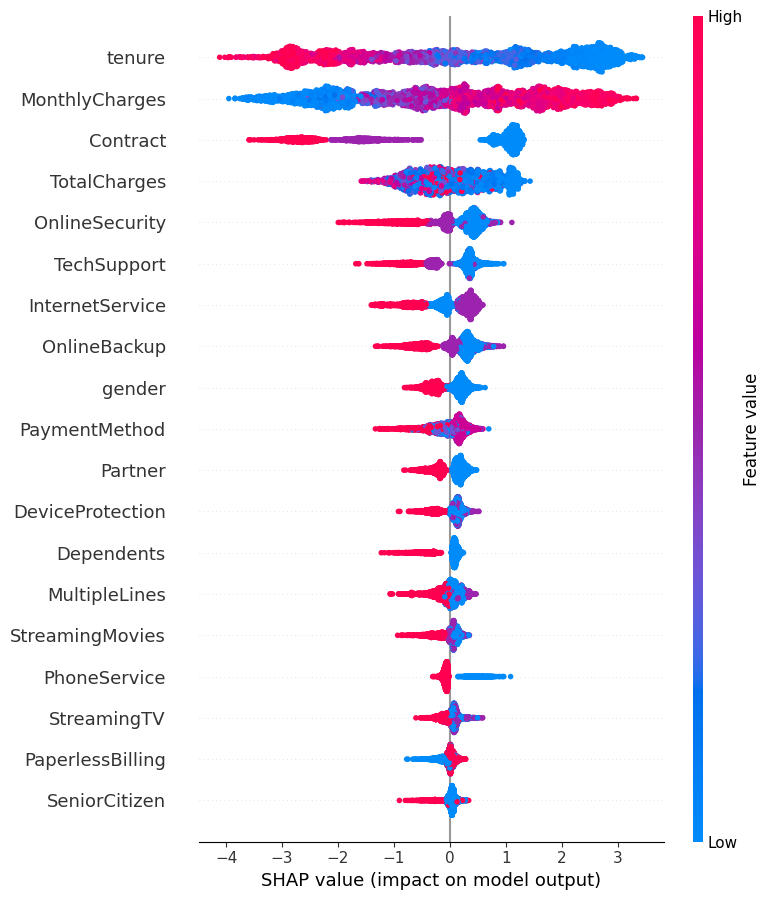

In [24]:
shap.summary_plot(shap_values, X_train_sap)


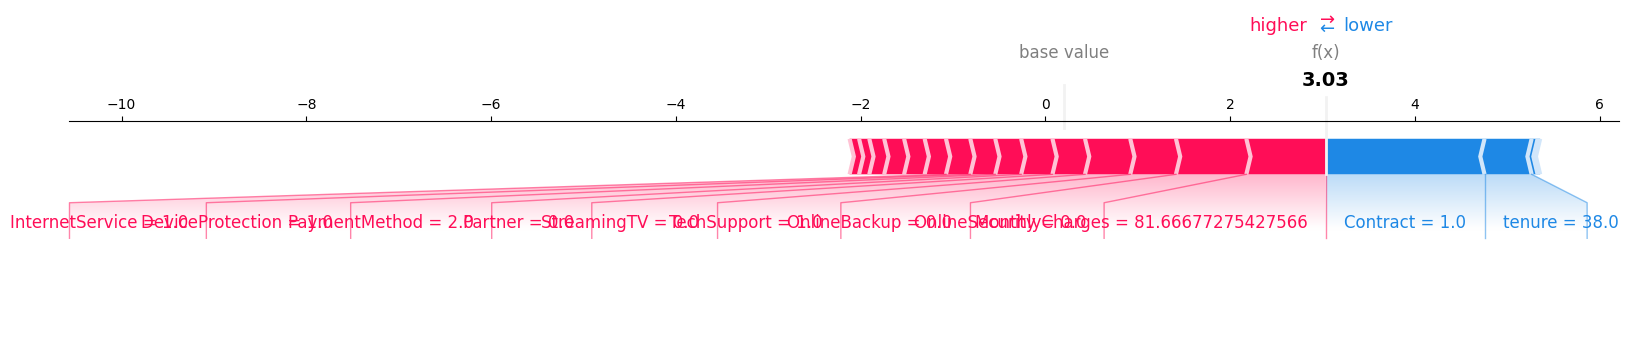

In [25]:
i = 5  # Choose any index from your training or test set
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_train_sap.iloc[i],  # or X_test_sap.iloc[i]
    matplotlib=True
)


In [26]:
import shap
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text

# Step 1: Compute SHAP values
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train_sap)

# Step 2: Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_train_sap.columns)

# Step 3: Combine with original features and target
combined = X_train_sap.copy()
combined["churn"] = y_train_sap.values
combined["shap_sum"] = shap_df.abs().sum(axis=1)

# Step 4: Identify high-impact samples
high_impact_customers = combined.sort_values(by="shap_sum", ascending=False).head(50)

# Optional: Explore risky patterns
print("High-risk churner summary:")
print(high_impact_customers[high_impact_customers["churn"] == 1][["MonthlyCharges", "tenure", "Contract", "TechSupport", "OnlineSecurity"]].describe())

# Step 5: Auto-generate rules using shallow decision tree on top SHAP features
top_features = shap_df.abs().mean().sort_values(ascending=False).head(5).index.tolist()

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train_sap[top_features], y_train_sap)

# Output rules
print("\n🔍 Interpretable Rules Extracted from Top SHAP Features:")
print(export_text(dt, feature_names=top_features))


High-risk churner summary:
       MonthlyCharges     tenure  Contract  TechSupport  OnlineSecurity
count       23.000000  23.000000      23.0    23.000000       23.000000
mean        76.345009  13.956522       0.0     0.260870        0.173913
std         24.366942  16.184949       0.0     0.619192        0.491026
min         19.550000   1.000000       0.0     0.000000        0.000000
25%         69.772823   1.000000       0.0     0.000000        0.000000
50%         85.350000   2.000000       0.0     0.000000        0.000000
75%         93.911918  31.500000       0.0     0.000000        0.000000
max        107.350000  47.000000       0.0     2.000000        2.000000

🔍 Interpretable Rules Extracted from Top SHAP Features:
|--- Contract <= 0.50
|   |--- MonthlyCharges <= 30.55
|   |   |--- TotalCharges <= 38.33
|   |   |   |--- class: 1
|   |   |--- TotalCharges >  38.33
|   |   |   |--- class: 0
|   |--- MonthlyCharges >  30.55
|   |   |--- tenure <= 21.50
|   |   |   |--- class: 1
|  